# Efficient Clustering of Genetic Entities

The notebook demonstrates computational efficiency and simplicity of the convolution-based dissimilarity in application to genomics.

An outline of the notebook is as follow:

- we start with introducing generic functions for comparing strings using FFT convolution (a known technique with a new twist),
- we compare convolution-based dissimilarity properties to those of Levenshtein distance with simple computational experiments,
- finally, we load sample data containing sequences for several coronaviruses and construct a phylogenetic tree for that set. 

## Standard imports

See also requirements.txt for the complete information.

In [1]:
import os

# The usual imports to compute and plot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
%matplotlib inline

## Strings encoding

We construct a one-hot encoding of an input string into multiple channels.

The input is a string (text, sequence - we use these terms interchangeably) in a finite alphabet. For genomics, the alphabet contains four symbols (A, C, G, T), but the approach applies to any finite alphabet. The output is a numpy binary array with dimensions (input length, alphabet size).

In [2]:
# Indexing for mapping four binary sequences from a text in the alphabet {A, C, G, T}
# Note that the order of the symbols defines the mapping to the "channels", i.e., rows in 
# the target numpy array.
ALPHABET_ACGT = ['A', 'C', 'G', 'T']

In [3]:
def encode_binary_channels(seq, alphabet=ALPHABET_ACGT):
    """ Encode input text in the alphabet using one-hot encoding, 
    e.g., a string in {A, C, G, T} alphabet maps to a numpy array [4, Length]
    where 1s encode symbols by channel. For that purpose, we fix the order 
    of symbols in the alphabet."""
    indexes = {sym: idx for idx, sym in enumerate(alphabet)}
    arr = np.zeros((len(alphabet), len(seq)))
    for ii, entry in enumerate(seq):
        if entry in indexes:  # if not in the alphabet, the symbol becomes 0 in all channels 
            arr[indexes[entry], ii] = 1
    return arr

In [4]:
# A quick illustation of the output:
encode_binary_channels('ACGTTGCA')

array([[1., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 1., 0., 0., 0.]])

## FFT utils

In our approach, we use a comparison of binary sequences via convolution. It requires FFT for fast computation of polynomial multiplication. In this subsection, we define some useful utilities for that.

In [5]:
# FFT-based convolution utilities to simplify polynomials multiplication
# Polynomials are defined via an array of their coefficients.
# A comprehensive explanation of that technique can be found, e.g, here 
# http://www.cs.toronto.edu/~denisp/csc373/docs/tutorial3-adv-writeup.pdf

def fft_poly_mult(arr_a, arr_b):
    """ Takes in coefficients as numpy arrays or Python lists. """
    pad_to_length = len(arr_a) + len(arr_b) - 1
    a_f = np.fft.fft(arr_a, pad_to_length)
    b_f = np.fft.fft(arr_b, pad_to_length)
    return np.real(np.fft.ifft(np.multiply(a_f,b_f)))

def fft_poly_mult_int(arr_a, arr_b):
    """ For our application, the result is expected to be integer.
    Round the fft results to integers and cast to int."""
    return np.round(fft_poly_mult(arr_a, arr_b)).astype(int)

In what follows, we consider only binary (0 and 1) coefficients of the polynomials.

In [6]:
# An illustration:
arr_a = [0, 1, 0, 1]
arr_b = [1, 1, 1]
a = np.array(arr_a, dtype=int)  # x + x^3
b = np.array(arr_b, dtype=int)  # 1 + x + x^2
ab = fft_poly_mult_int(a, b)
print(ab)

[0 1 1 2 1 1]


The **key observation** is that the cell result above shows the number of matches for the input sequences at different mutual shifts. That is the basis of the convolution-based method of comparing sequences.

## Normalization

We introduce normalization to put the numerical results of the sequences comparison into the unit scale. 

We introduce the "convolution of unities," which convolves sequences consisting only of 1s. It has a trapezoidal shape, and we use it as a denominator. Dividing by convolution of unity removes the trivial signal from the convolution of the binary sequences.

In [7]:
def normalized_binary_convolution(arr_a, arr_b):
    """ Scales the convolution of unity by the count of max possible matches between sequences."""
    sum_a = np.sum(arr_a)
    sum_b = np.sum(arr_b)
    max_expected_match = max(sum_a, sum_b)
    assert max_expected_match > 0, "Both inputs are const zero."
    ab = fft_poly_mult_int(arr_a, arr_b)
    return ab/max_expected_match

Compare to the unnormalized result:
[0.         0.33333333 0.33333333 0.66666667 0.33333333 0.33333333]


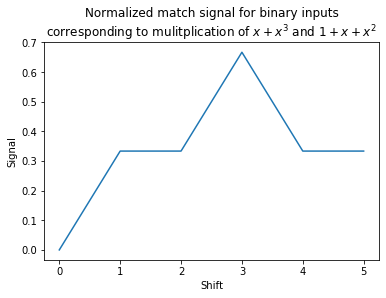

In [8]:
# A quick spot-check; compare to the output of a cell above with the same inputs.
res = normalized_binary_convolution(arr_a, arr_b)
print('Compare to the unnormalized result:')
print(res)

# Plot the "signal" of strings matching.
fig = plt.figure()
ax = plt.axes()
ax.plot(range(len(res)), res)
ax.set_ylabel('Signal')
ax.set_xlabel('Shift')
plt.title('Normalized match signal for binary inputs\ncorresponding to mulitplication of $x+x^3$ and $1+x+x^2$')
plt.savefig('binary_inputs_normalized_signal.pdf')
plt.show()


## Strings convolution

Using strings encoding into binary sequences and convolution-based comparison, we build tools for comparing strings via convolution.

In [9]:
# A utility for ensuring correctness of the input to strings convolution. 
# We require that both strings contain all symbols from the alphabet. 
# In particular, the inputs are not empty.
def validate_convolution_input(seq1, seq2, alphabet):
    assert len(seq1) > 0 and len(seq2) > 0, "Can't convolve empty string."
    num_symbols = len(alphabet)
    assert num_symbols > 1, "Passed in alphabet must contain at least two symbols."
    # Is the passed in alphabet redundants? i.e., is it the same as the alphabet present in seq1 and seq2?
    # That will result in zero channels, throwing off normalization.
    actual_alphabet = set(seq1 + seq2)
    intresection_len = len(actual_alphabet.intersection(alphabet))
    assert intresection_len == num_symbols, "The passed in alphabet and the joint sequences alphabet are different."
    return num_symbols

In [10]:
# Computes normalized number of matches of two input string at different mutual alignments.
def convolve_strings(seq1, seq2, alphabet=ALPHABET_ACGT):
    num_symbols = validate_convolution_input(seq1, seq2, alphabet)
    indexes = {sym: idx for idx, sym in enumerate(alphabet)}
    arr1 = encode_binary_channels(seq1[::-1], indexes)  # invert one of them
    arr2 = encode_binary_channels(seq2, indexes)
    res = []
    for channels in zip(arr1, arr2):
        ch1, ch2 = channels
        conv = normalized_binary_convolution(ch1, ch2)
        res.append(conv)
    return np.sum(res, axis=0)/num_symbols

The key observation stated earlier suggests that convolution provides an efficient tool for detecting matches when strings are superimposed one over the other. We provide some illustrations next.

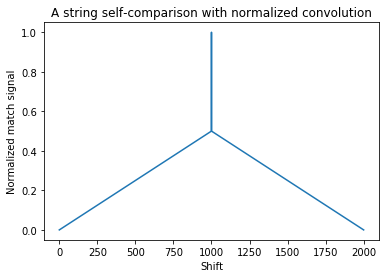

In [11]:
# An illustration of detecting matches with identical inputs strings at different mutual shifts
alphabet = ['X', 'Y']

# Test strings:
s1 = 'X'*1000 + 'Y'
res1 = convolve_strings(s1, s1, alphabet)  # A trivial case of identical imputs

# Plot the "signal" of strings matching.
fig = plt.figure()
ax = plt.axes()
ax.plot(range(len(res1)), res1)
ax.set_ylabel('Normalized match signal')
ax.set_xlabel('Shift')
plt.title('A string self-comparison with normalized convolution')
plt.savefig('string_self_comparison.pdf')
plt.show()

In [12]:
# Single edit in the input string. See also the plot in the next cell.
str_a = 'GATTACA'
str_b = 'GATTACC'
res = convolve_strings(str_a, str_b)
print('Normalized matches at different overlaps:')
print(res)
# The values can be verified using brute force.

Normalized matches at different overlaps:
[0.         0.08333333 0.         0.08333333 0.08333333 0.125
 0.79166667 0.25       0.         0.08333333 0.         0.
 0.        ]


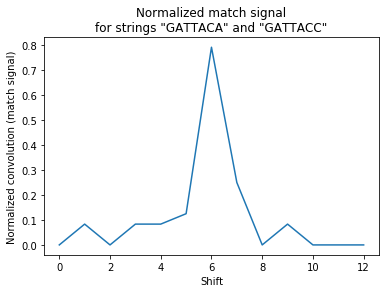

In [13]:
# Plot the output of strings convolution (i.e., matching at different shifts). 
fig = plt.figure()
ax = plt.axes()
ax.plot(range(len(res)), res)
ax.set_ylabel('Normalized convolution (match signal)')
ax.set_xlabel('Shift')
plt.title('Normalized match signal\nfor strings "GATTACA" and "GATTACC"')
plt.savefig('GATTACAx2.pdf')
plt.show()

## Normalized best-match value as a measure of strings similarity

It is helpful to extract a single number characterizing the similarity of two strings. We use the max of the normalized convolution as a measure of similarity. It is easy to see that self-similarity equals 1 for a string of any length.

In [14]:
def strings_max_of_fft_similarity(seq1, seq2, alphabet=ALPHABET_ACGT):
    validate_convolution_input(seq1, seq2, alphabet)
    res = convolve_strings(seq1, seq2, alphabet)
    return np.max(res)

In [15]:
# Spot-check: a string has self-similarity = 1
strings_max_of_fft_similarity(s1, s1, alphabet)

1.0

## Dissimilarity constructed from normalized best match

For clustering and phylogenetic trees construction in bioinformatics, we need a metric that is the opposite of similarity. There are many ways of constructing it. A simlpe way of doing that is: 

$$\delta(a, b) = \frac{1}{\beta(a, b)} - 1$$

where $\beta(a, b)$ is the best match of strings $a$ and $b$ intriduced above. 

In [16]:
def strings_max_fft_diff(seq1, seq2, alphabet=ALPHABET_ACGT):
    return 1.0/strings_max_of_fft_similarity(seq1, seq2, alphabet) - 1.0

The proposed quantity has these easily verifiable properties: 

* it is symmetric $\delta(a, b) = \delta(b, a)$
* it equals zero for the identical arguments: $\delta(a,a)=0$, i.e. dissimilarity of $a$ to itself is 0.

The introduced **convolution dissimilarity** has lots of commonalities with Hamming distance. Unfortunately, as we define it, it is not a distance. It fails triangle inequality, which we show next with a counterexample. 

In [17]:
# These three strings fail triangle inequality:
a = 'ab' 
b = 'aba' 
c = 'ba'
ab = strings_max_fft_diff(a, b, alphabet=['a','b'])
bc = strings_max_fft_diff(b, c, alphabet=['a','b'])
ca = strings_max_fft_diff(c, a, alphabet=['a','b'])

print(ab, bc, ca)
if ab + bc < ca: 
    print('Triangle inequality fails')

0.33333333333333326 0.33333333333333326 1.0
Triangle inequality fails


Failing triangle inequality appears to be solely an artifact of different input (sub)strings lengths and maximizing across all mutual alignments. Opposite to that, Hamming distance defines the dissimilarity of sequences of the same dimensionality at a single alignment.

Despite that, the proposed **convolution dissimilarity** is useful as it grows monotonously with the Levenshtein distance, as we show next.

## Some string utilities

In this technical section, we define some simple string utilities that we use to explore the convolution-based comparison properties.

In [18]:
def random_string(length, alphabet=ALPHABET_ACGT):
    """ Generates a string with the uniform distribution of symbols from the provided alphabet. """
    return "".join(random.choice(alphabet) for ii in range(length))

In [19]:
# A random mutation of a string preserving its length
def mutate_string(s, alphabet=ALPHABET_ACGT):
    """ With equal probabilities, the function: 
    - flips a symbol at a random position, 
    - inserts a random symbols, or 
    - deletes one while adding one at the tail or at the head of the string metated string. 
    """
    length = len(s)
    rand = random.random()
    if rand > 2/3:  # flip a symbol
        pos = random.randint(0, length - 1)
        res = s[:pos] + random.choice(alphabet) + s[pos+1:]
        return res
    elif rand > 1/3: # deletion
        pos = random.randint(0, length - 1)
        res = s[:pos] + s[pos + 1:]
        if random.random() > 0.5:
            res = res + random.choice(alphabet)
        else:
            res = random.choice(alphabet) + res
        return res
    else: # insertion
        pos = random.randint(0, length - 1)
        res = s[:pos] + random.choice(alphabet) + s[pos:-1]
        return res

In [20]:
# A quick illustration and a spot-check:
s0 ='GATTACA'
s1 = mutate_string(s0)
print(len(s0), s0)
print(len(s1), s1)

7 GATTACA
7 GATTTAC


### The convolution dissimilarity is a (nonlinear) proxy for Levenshtein distance

A direct comparison with Levenshtein distance is a simple computational experiment. We run it using the standard implementation from the Python Levenshtein package.

In [21]:
import time
from collections import defaultdict
from Levenshtein import distance as levenshtein_distance

TEST_STR_LEN = 512  # fix the length of the test strings

# Collect Levenshtein distances and convolution dissimilarities 
# for the same strings obtained by random mutations.
pairs_lev_conv = defaultdict(list)

t0 = time.time()
for jj in range(1024):
    if jj % 100 == 0:
        print(jj, 'time elapsed (sec):', int(time.time() - t0))
    # Fix the string s0 from which we compute mutations:
    s0 = random_string(TEST_STR_LEN)   
    # Both values below are zeros (no mutations yet), we're keeping these for completness
    lev_dist = levenshtein_distance(s0, s0)
    pairs_lev_conv[lev_dist].append(strings_max_fft_diff(s0, s0))
    s1 = s0
    for ii in range(400):
        s2 = mutate_string(s1)
        lev_dist = levenshtein_distance(s0, s2)
        pairs_lev_conv[lev_dist].append(strings_max_fft_diff(s0, s2))
        s1 = s2
print('Total time =', int(time.time() - t0), 'sec')
print('Done.')

0 time elapsed (sec): 0
100 time elapsed (sec): 45
200 time elapsed (sec): 91
300 time elapsed (sec): 137
400 time elapsed (sec): 182
500 time elapsed (sec): 227
600 time elapsed (sec): 272
700 time elapsed (sec): 317
800 time elapsed (sec): 362
900 time elapsed (sec): 407
1000 time elapsed (sec): 452
Total time = 463 sec
Done.


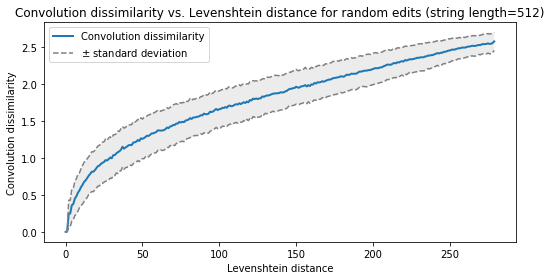

In [22]:
# Visualize convolution dissimilarity against Levenshtein distance.
SCALE = 10

lev_dists, means, stdevs = zip(*sorted([(key, np.mean(val), np.std(val)) for key, val in pairs_lev_conv.items()]))
lower = np.array(means) - np.array(stdevs)
upper = np.array(means) + np.array(stdevs)

fig = plt.figure(figsize=(8, 4))
ax = plt.axes()

SLICE = 280  # The tail is noiser due to fewer samples but sgma is smaller

ax.plot(lev_dists[:SLICE], means[:SLICE], linewidth=2, label='Convolution dissimilarity')
ax.plot(lev_dists[:SLICE], lower[:SLICE], linestyle='dashed', color='grey', label='$\pm$ standard deviation')
ax.plot(lev_dists[:SLICE], upper[:SLICE], linestyle='dashed', color='grey')
ax.fill_between(lev_dists[:SLICE], lower[:SLICE], upper[:SLICE], facecolor='grey', alpha=0.15)

ax.set_ylabel('Convolution dissimilarity')
ax.set_xlabel('Levenshtein distance')
plt.legend()
plt.title('Convolution dissimilarity vs. Levenshtein distance for random edits (string length=512)')
plt.tight_layout()
plt.savefig('distance_compare.pdf')
plt.show()

The computational experiment above suggests that the introduced dissimilarity is a reasonable proxy for Levenshtein distance (and the number of edits/mutations). We may consider using it instead of Levenshtein distance in some applications where the input is too long for other algorithms. One possible example is constructing phylogenetic trees discussed next. 

## Application to phylogenetic trees in genomics

We use several coronaviruses to demonstrate the application of the proposed convolution dissimilarity. The coronavirus data is available in open access. We use it in FASTA format.

### Loading genomes data with Biopython

In [23]:
from Bio import SeqIO

In [24]:
fname = '76genomes.fasta'
fasta_records = SeqIO.parse(fname, "fasta")

genomes = {}
valid_records = 0
for record in fasta_records:
    # print(record.id)
    symbols = set(record.seq)
    # Some checks that could be useful for custom data:
    # if len(symbols) != 4:
    #    print(record.id, 'contains more than four unique symbols in the sequence:', symbols)
        # continue - keep going, we will replace stray symbols with all 0s later. 
    genomes[record.id] = record
    print(record.description)
    valid_records += 1
# print(f'Found {len(genomes)} records.')
# print(genomes.keys())
print('Found', valid_records, 'valid records.')

NC_048217.1 Murine hepatitis virus strain A59, complete genome
NC_048216.1 NL63-related bat coronavirus strain BtKYNL63-9b, complete genome
NC_048214.1 Duck coronavirus isolate DK/GD/27/2014, complete genome
NC_048213.1 Infectious bronchitis virus isolate Ind-TN92-03, complete genome
NC_046965.1 Canada goose coronavirus strain Cambridge_Bay_2017, complete genome
NC_045512.2 Severe acute respiratory syndrome coronavirus 2 isolate Wuhan-Hu-1, complete genome
NC_032730.1 Lucheng Rn rat coronavirus isolate Lucheng-19, complete genome
NC_034440.1 Bat coronavirus isolate PREDICT/PDF-2180, complete genome
NC_006213.1 Human coronavirus OC43 strain ATCC VR-759, complete genome
NC_034972.1 Coronavirus AcCoV-JC34, complete genome
NC_039207.1 Betacoronavirus Erinaceus/VMC/DEU/2012 isolate ErinaceusCoV/2012-174/GER/2012, complete genome
NC_038861.1 Transmissible gastroenteritis virus complete genome, genomic RNA
NC_038294.1 Betacoronavirus England 1 isolate H123990006, complete genome
NC_011547.1 B

In [25]:
# A spot-check and another illustration of encoding:
seq = genomes['NC_048216.1'].seq
print(seq[:3], '...', seq[-3:])
arr = encode_binary_channels(seq)
print(arr)

TGA ... CTT
[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 1. 1.]]


In [26]:
# Test dissimilarity on two sequences "in the wild"
v1 = 'NC_001451.1'
v2 = 'NC_002306.3'
s1 = genomes[v1].seq
s2 = genomes[v2].seq
s0 = random_string(min(len(s1), len(s2)))
dist12 = strings_max_fft_diff(s1, s2)
print('%s\t<-> %s\t\t%2.2f' % (v1, v2, dist12))
dist02 = strings_max_fft_diff(s0, s2)
print('random\t\t<-> %s\t\t%2.2f' % (v2, dist02))
dist01 = strings_max_fft_diff(s0, s1)
print('random\t\t<-> %s\t\t%2.2f' % (v1, dist01))
s00 = random_string(min(len(s1), len(s2)))
dist00 = strings_max_fft_diff(s0, s00)
print('random\t\t<-> random\t\t%2.2f' % dist00)

NC_001451.1	<-> NC_002306.3		2.61
random		<-> NC_002306.3		3.53
random		<-> NC_001451.1		3.42
random		<-> random		2.91


The dissimilarities computed in the cell above show that the sequences for viruses are much more similar than random ones. Two random strings are more alike than a random string and a virus. The lower value for dissimilarity shows that the two sequences have structures with lots in common.

## Genomes pair-wise dissimilarities

To move to our main application (phylogenetic tree construction), we need to compute pair-wise dissimilarities for the coronaviruses from the set at hand.

In [27]:
# Computing pair-wise dissimilarities.

names = list(genomes.keys())
num_names = len(names)
print('Processing %d genomes' % num_names)

t0 = time.time()
distances = np.zeros((num_names, num_names))
counter = 0
total_pairs = int(len(names)*(len(names) + 1)/2)
print('total_pairs=', total_pairs)
for ii, name1 in enumerate(sorted(names)):
    seq1 = genomes[name1].seq
    for jj, name2 in enumerate(sorted(names)):
        if jj > ii:  # distances are symmetric
            break
        counter += 1
        percentage = int(100*counter/total_pairs)
        if counter % 256 == 0 or counter == 10:
            dt = time.time() - t0
            time_remaining = dt * (total_pairs - counter)/counter
            print('Completed %d percent. %d seconds remain.' % (percentage, int(time_remaining)))
        seq2 = genomes[name2].seq
        dist12 = strings_max_fft_diff(seq1, seq2)
        distances[ii, jj] = dist12
        distances[jj, ii] = dist12
t1 = time.time()
print('Completed in %d seconds.' % int(t1 - t0))

Processing 76 genomes
total_pairs= 2926
Completed 0 percent. 407 seconds remain.
Completed 8 percent. 382 seconds remain.
Completed 17 percent. 345 seconds remain.
Completed 26 percent. 315 seconds remain.
Completed 34 percent. 273 seconds remain.
Completed 43 percent. 236 seconds remain.
Completed 52 percent. 199 seconds remain.
Completed 61 percent. 162 seconds remain.
Completed 69 percent. 125 seconds remain.
Completed 78 percent. 88 seconds remain.
Completed 87 percent. 52 seconds remain.
Completed 96 percent. 15 seconds remain.
Completed in 416 seconds.


In [28]:
def save_dissimilarities_matrix(distances, fname):
    lines = []
    for ii, name1 in enumerate(sorted(names)):
        key1 = genomes[name1].id
        for jj, name2 in enumerate(sorted(names)):
            key2 = genomes[name2].id
            d = distances[ii, jj]
            line = "%s,%s,%f" %(key1, key2, d)
            lines.append(line + '\n')
    # print(lines[:3])
    # print(lines[-3:])
    with open(fname, 'w') as outfile:
        outfile.writelines(lines)
fname = 'dissimilarities_76x76.csv'
save_dissimilarities_matrix(distances, fname)
print('Saved matrix to file: %s' % fname)

Saved matrix to file: dissimilarities_76x76.csv


## Clustering and tree construction

With the dissimilarities matrix, we can construct a corresponding phylogenetic tree using AgglomerativeClustering from scikit-learn.

In [29]:
# Using AgglomerativeClustering to generate a tree in the Newick format 
# (see, e.g., https://evolution.genetics.washington.edu/phylip/newicktree.html).
# We can model Newick format as a nested dictionary then convert the structure to a string. 
# The values in the dictionary are lengths of edges. For this test all of them are of unit length.
from collections import defaultdict
from sklearn.cluster import AgglomerativeClustering
names = list(sorted(genomes.keys()))
root_to_leaves_paths = {name: [] for name in names}  # paths in the tree

for n_clus in range(2, 76, 1):
    cluster = AgglomerativeClustering(affinity='precomputed', linkage='single', n_clusters=n_clus)
    model = cluster.fit(distances)
    for ii, name in enumerate(names):
        root_to_leaves_paths[name].append(model.labels_[ii])


In [30]:
# Constructing the tree for plotting.
# An alternative approach: 
# https://stackoverflow.com/questions/35490371/how-to-visualize-dendrogram-a-dictionary-of-hierarchical-items

def attach(leaf_name, branch, parent):
    """ We can still assume an euqal depth for each path, 
    will eliminate that assumption in our future work. """
    # print(leaf_name, branch, parent)
    node = branch[0]
    if len(branch) == 1:  # branch ending with a leaf
        leaves = parent.get(node, list())
        leaves.append(leaf_name)
        parent[node] = leaves
    else:
        child = parent.get(node, dict())
        parent[node] = child
        attach(leaf_name, branch[1:], child)
        
def tree_to_str(tree):
    if type(tree) == list:
        return str(tree).replace('[', '(').replace(']', ')')
    else:
        res = '('
        for subtree in tree.values():
            res += tree_to_str(subtree) + ','
        res = res[:-1] + '),'
        return res

def convert_tree_to_str(tree):
    """ Obtain the tree in the Newick format"""
    tree_str = tree_to_str(tree)
    tree_str = tree_str[:-1] + ';'
    tree_str = tree_str.replace("'", "")
    tree_str = tree_str.replace(",)", ")")
    while tree_str.find(',,') >= 0:
        tree_str = tree_str.replace(",,",",")
    return tree_str

In [31]:
tree = {}
for leaf_name, branch in root_to_leaves_paths.items():
    attach(leaf_name, branch, tree)

tree_str = convert_tree_to_str(tree)

# print(tree_str) # That is not human-readable anyway. 

We use ETE toolkit for trees vizualisation. Here is a useful post:
https://stackoverflow.com/questions/35490371/how-to-visualize-dendrogram-a-dictionary-of-hierarchical-items

In [34]:
# ETE is a common tool for phylogenetic research
# http://etetoolkit.org/docs/latest/index.html
from ete3 import Tree, TreeStyle, NodeStyle

t = Tree(tree_str)
ts = TreeStyle()
ts.show_leaf_name = True
ts.scale =  5 # 120 pixels per branch length unit
# ts.rotation = 90

# Draws nodes as small red spheres of diameter equal to 0 pixels
nstyle = NodeStyle()
nstyle["size"] = 0
nstyle["fgcolor"] = "black"
for n in t.traverse():
    n.set_style(nstyle)
    record = genomes.get(n.name)
    if record is not None:
        long_name = n.name + ' ' + ' '.join(record.description.split()[1:4])
        shorter_name = long_name.replace(',','').replace('complete','')
        if len(shorter_name) > 28:
            shorter_name = shorter_name[:24] + '...'
        n.name = shorter_name

_ = t.render("corona_viruses_tree_76.pdf", tree_style=ts)
_ = t.render("corona_viruses_tree_76.png", tree_style=ts)
# t.show()

## Appendix: generating *requirements.txt*

See https://towardsdatascience.com/generating-a-requirements-file-jupyter-notebook-385f1c315b52 (the last recipe) for obtaining requirements.txt from a Jupyter notebook.